In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from scipy.interpolate import interp1d

In [ ]:
df = pd.read_csv("/content/email.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:

df.dropna(subset=['Category', 'Message'], inplace=True)

df['Category'] = df['Category'].map({'spam': 1, 'ham': 0})

df.dropna(subset=['Category'], inplace=True)

X = df['Message']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

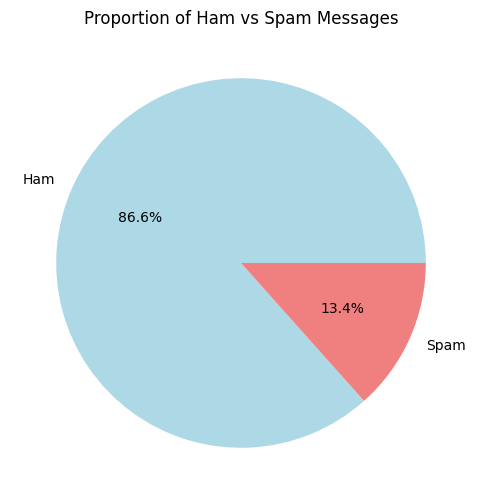

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

model = MultinomialNB(alpha=1.0)
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)
y_proba = model.predict_proba(X_test_vectorized)[:, 1]

plt.figure(figsize=(6, 6))
df['Category'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Ham', 'Spam'], colors=['lightblue', 'lightcoral'])
plt.title('Proportion of Ham vs Spam Messages')
plt.ylabel('')
plt.show()

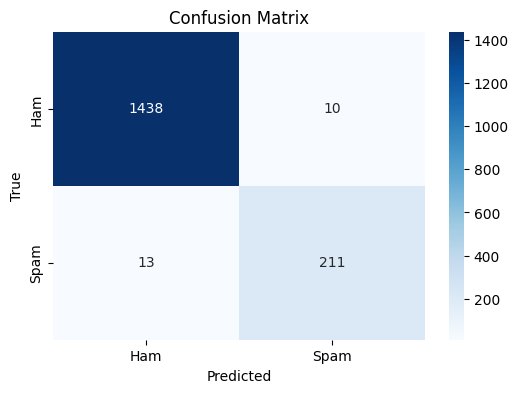

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

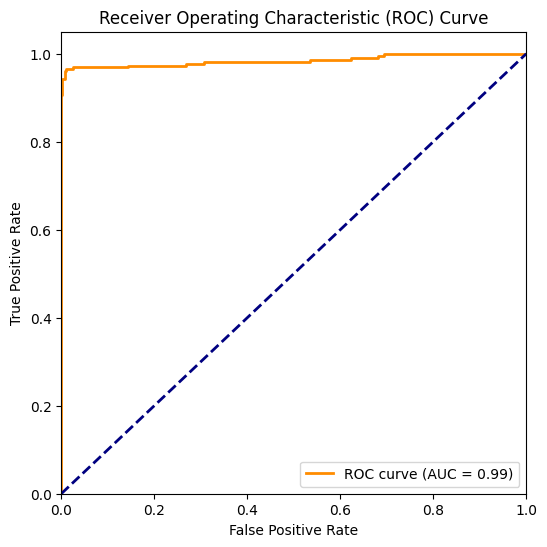

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

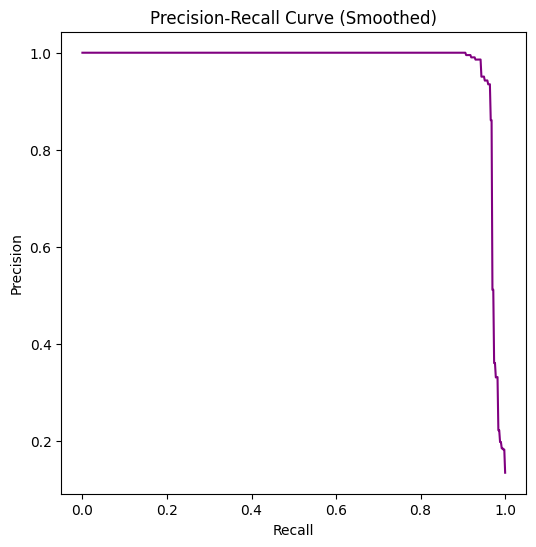

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)

recall_interp = np.linspace(recall.min(), recall.max(), 500)
precision_interp = interp1d(recall[::-1], precision[::-1], kind='linear')(recall_interp)

plt.figure(figsize=(6, 6))
plt.plot(recall_interp, precision_interp, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Smoothed)')
plt.show()

In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_probs = model.feature_log_prob_[1, :] - model.feature_log_prob_[0, :]

In [ ]:
top_n = 20
top_n_indices = np.argsort(feature_probs)[-top_n:]

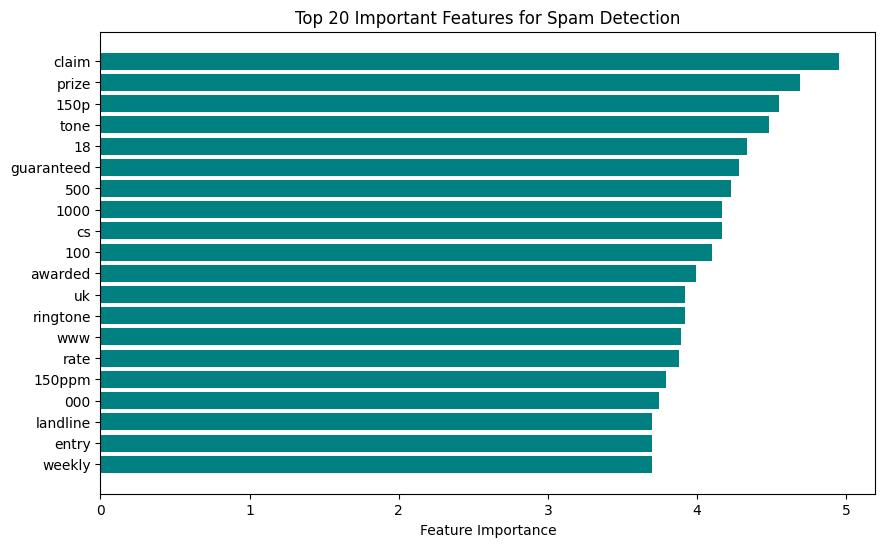

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[top_n_indices], feature_probs[top_n_indices], color='teal')
plt.title(f'Top {top_n} Important Features for Spam Detection')
plt.xlabel('Feature Importance')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
})

print(metrics)

      Metric     Score
0   Accuracy  0.986244
1  Precision  0.954751
2     Recall  0.941964
3   F1-Score  0.948315


In [ ]:
thresholds = np.linspace(0, 1, 1000)
precisions = []
recalls = []

for threshold in thresholds:
    preds = (y_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test, preds, zero_division=0))
    recalls.append(recall_score(y_test, preds))

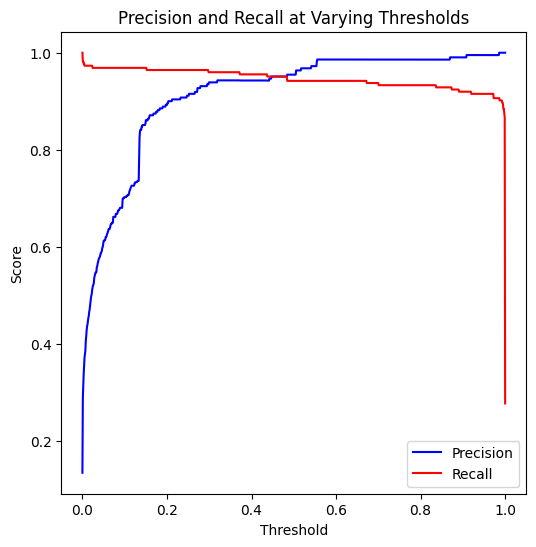

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall at Varying Thresholds')
plt.legend()
plt.show()